In [108]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

num_points = 20
critical_radius = 2
d_max = 1.5
rho_threshold = 0.1
distance_threshold = 1.0

num_qubits = int(np.ceil(np.log2(num_points)))
dev = qml.device("default.qubit", wires=num_qubits + 12)  # More wires for oracle

# Generate sample 3D points
np.random.seed(42)
points = np.random.rand(num_points, 3)
points += 0.05 * np.random.randn(*points.shape)
dist_matrix = np.linalg.norm(points[:, None, :] - points[None, :, :], axis=2)

# Encode 3D points into 1D features (scaled for 3-bit integers)
x_data = np.round(np.linalg.norm(points, axis=1) * 7 / np.max(np.linalg.norm(points, axis=1))).astype(int)
rho_data = np.zeros(num_points, dtype=int)  # will be filled by quantum oracle later


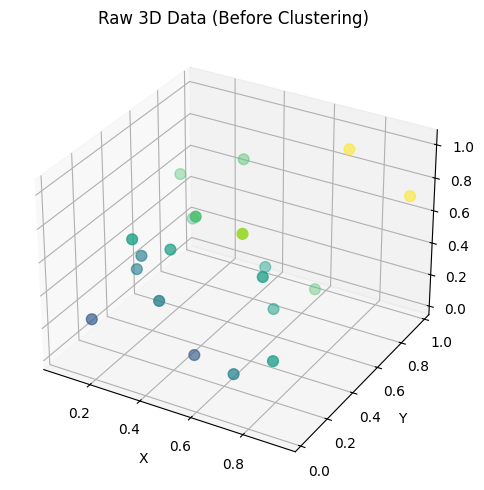

In [109]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

# Plot raw points
colors = plt.cm.viridis(x_data / x_data.max())
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, s=60)

ax.set_title("Raw 3D Data (Before Clustering)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.tight_layout()
plt.show()


In [110]:
def apply_oracle(x_data, rho_data, x_j, rho_j, dL, dT):
    num_qubits = int(np.ceil(np.log2(len(x_data))))
    idx_wires = list(range(num_qubits))                    # 0..(num_qubits - 1)
    xi_wires = [num_qubits + 0, num_qubits + 1, num_qubits + 2]
    rhoi_wires = [num_qubits + 3, num_qubits + 4, num_qubits + 5]
    dist2_wires = [num_qubits + 6, num_qubits + 7, num_qubits + 8]
    anc_dlow = num_qubits + 9
    anc_dhigh = num_qubits + 10
    anc_rho = num_qubits + 11

    # === LOAD x_i and rho_i using classical control logic ===
    for i in range(len(x_data)):
        bits = np.binary_repr(i, width=num_qubits)[::-1]
        cond = [idx_wires[j] for j, b in enumerate(bits) if b == '1']
    
        x_bits = np.binary_repr(x_data[i], width=3)[::-1]
        rho_bits = np.binary_repr(rho_data[i], width=3)[::-1]
    
        if len(cond) == 0:
            # Apply unconditionally if i == 0
            for j, b in enumerate(x_bits):
                if b == '1':
                    qml.PauliX(wires=xi_wires[j])
            for j, b in enumerate(rho_bits):
                if b == '1':
                    qml.PauliX(wires=rhoi_wires[j])
        else:
            # Apply conditionally using qml.ctrl
            for j, b in enumerate(x_bits):
                if b == '1':
                    qml.ctrl(qml.PauliX, control=cond)(wires=xi_wires[j])
            for j, b in enumerate(rho_bits):
                if b == '1':
                    qml.ctrl(qml.PauliX, control=cond)(wires=rhoi_wires[j])


    # === DISTANCE^2 = (x_i - x_j)^2 (simplified for 3-bit inputs) ===
    for j in range(3):
        if (x_j >> j) & 1:
            qml.PauliX(wires=xi_wires[j])
    for j in range(3):
        qml.CNOT(wires=[xi_wires[j], dist2_wires[j]])
    for j in range(3):
        if (x_j >> j) & 1:
            qml.PauliX(wires=xi_wires[j])

    # === COMPARATORS ===
    def compare_greater(a_wires, b_val, ancilla):
        b_bits = np.binary_repr(b_val, width=len(a_wires))[::-1]
        for i, bit in enumerate(b_bits):
            if bit == '0':
                qml.PauliX(wires=a_wires[i])
    
        qml.MultiControlledX(wires=a_wires[:-1] + [ancilla])
    
        for i, bit in enumerate(b_bits):
            if bit == '0':
                qml.PauliX(wires=a_wires[i])
    
    # Run comparisons
    compare_greater(dist2_wires, int(dL), anc_dlow)
    compare_greater(dist2_wires, int(dT), anc_dhigh)
    compare_greater(rhoi_wires, rho_j, anc_rho)
    
    # === Final marking ===
    qml.MultiControlledX(wires=[anc_dlow, anc_dhigh, anc_rho, idx_wires[-1]])


def diffusion_operator():
    for wire in range(num_qubits):
        qml.Hadamard(wires=wire)
        qml.PauliX(wires=wire)

    qml.Hadamard(wires=num_qubits - 1)
    qml.MultiControlledX(
        wires=list(range(num_qubits - 1)) + [num_qubits - 1],
        control_values=[1] * (num_qubits - 1)
    )
    qml.Hadamard(wires=num_qubits - 1)

    for wire in range(num_qubits):
        qml.PauliX(wires=wire)
        qml.Hadamard(wires=wire)

def grover_iterations(index, num_iter=1):
    x_j = int(x_data[index])
    rho_j = int(rho_data[index])
    dL = 0
    dT = critical_radius

    @qml.qnode(dev)
    def circuit():
        for wire in range(num_qubits):
            qml.Hadamard(wires=wire)

        for _ in range(num_iter):
            apply_oracle(
                x_data=x_data,
                rho_data=rho_data,
                x_j=x_j,
                rho_j=rho_j,
                dL=dL,
                dT=dT
            )
            diffusion_operator()

        return qml.probs(wires=range(num_qubits))

    return circuit()


In [111]:
def compute_local_densities(threshold=0.01):
    densities = []
    for index in range(num_points):
        # Step 1: Probe with 1 Grover iteration
        initial_probs = grover_iterations(index, num_iter=1)
        valid_probs = initial_probs[:num_points]
        marked = [i for i, p in enumerate(valid_probs) if p > threshold and i != index]

        # Step 2: Estimate optimal number of Grover iterations
        k = len(marked)
        num_iter = max(1, int(np.floor(np.pi / 4 * np.sqrt(k)))) if k > 0 else 1

        # Step 3: Full Grover run
        probs = grover_iterations(index, num_iter=num_iter)
        valid_probs = probs[:num_points]

        # Step 4: Estimate density (excluding self)
        density = sum(p for i, p in enumerate(valid_probs) if i != index)
        densities.append(density)

    return np.array(densities)


In [112]:
def find_nearest_higher(index, densities, d_max):
    x_j = int(x_data[index])
    rho_j = int(np.round(densities[index] * 7))

    dL = 0
    dH = d_max
    best_i = index
    max_steps = num_qubits

    for _ in range(max_steps):
        @qml.qnode(dev)
        def circuit():
            for wire in range(num_qubits):
                qml.Hadamard(wires=wire)

            apply_oracle(
                x_data=x_data,
                rho_data=np.round(densities * 7).astype(int),
                x_j=x_j,
                rho_j=rho_j,
                dL=int(np.round(dL)),
                dT=int(np.round(dH))
            )

            diffusion_operator()

            return qml.probs(wires=range(num_qubits))

        probs = circuit()[:num_points]

        if max(probs) < 0.01:
            break  # No strong candidate found

        i_star = np.argmax(probs)
        if i_star == index:
            break  # No valid better point found

        best_i = i_star
        d_star = np.linalg.norm(points[index] - points[best_i])
        dH = (d_star + dL) / 2  # shrink search window

    return best_i

def compute_all_nearest_highers(densities, d_max):
    return np.array([
        find_nearest_higher(i, densities, d_max)
        for i in range(num_points)
    ])


In [123]:
def assign_clusters_from_nh_with_outliers(nearest_higher, densities,
                                          rho_threshold=0.005, distance_threshold=1.0):
    clusters = np.full(num_points, -1)
    current_cluster = 0

    # === SEEDS ===
    for i in range(num_points):
        if nearest_higher[i] == i and densities[i] > rho_threshold:
            dist_to_nh = np.linalg.norm(points[i] - points[nearest_higher[i]])
            if dist_to_nh > distance_threshold:
                clusters[i] = current_cluster
                current_cluster += 1

    # Followers
    for i in range(num_points):
        if clusters[i] == -1:
            nj = nearest_higher[i]
            dist_ij = np.linalg.norm(points[i] - points[nj])
            if densities[i] < rho_threshold and dist_ij > distance_threshold:
                clusters[i] = -1  # Mark as outlier
            else:
                # Walk uphill until hitting a cluster seed
                path = [i]
                while clusters[nj] == -1 and nj != nearest_higher[nj]:
                    path.append(nj)
                    nj = nearest_higher[nj]
                cluster_id = clusters[nj] if clusters[nj] != -1 else -1
                for node in path:
                    clusters[node] = cluster_id

    return clusters


In [124]:
# Compute local densities via Grover-based quantum oracle
densities = compute_local_densities()

# Find nearest-higher points using quantum oracle with binary search
nearest_higher = compute_all_nearest_highers(densities, d_max)

# Assign clusters and label outliers
clusters = assign_clusters_from_nh_with_outliers(
    nearest_higher,
    densities,
    rho_threshold=rho_threshold,
    distance_threshold=distance_threshold
)

# Count how many points are in each cluster
cluster_counts = Counter(clusters)

print("Raw cluster labels:", clusters)
print("Number of non-outliers:", np.sum(clusters != -1))
print("Cluster counts:", Counter(clusters))

# Relabel singleton clusters as outliers (-1)
singleton_ids = [cid for cid, count in cluster_counts.items() if count == 1]
for i in range(len(clusters)):
    if clusters[i] in singleton_ids:
        clusters[i] = -1

print("Cluster labels with outliers:", clusters)


Raw cluster labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Number of non-outliers: 20
Cluster counts: Counter({tensor(0, requires_grad=True): 20})
Cluster labels with outliers: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


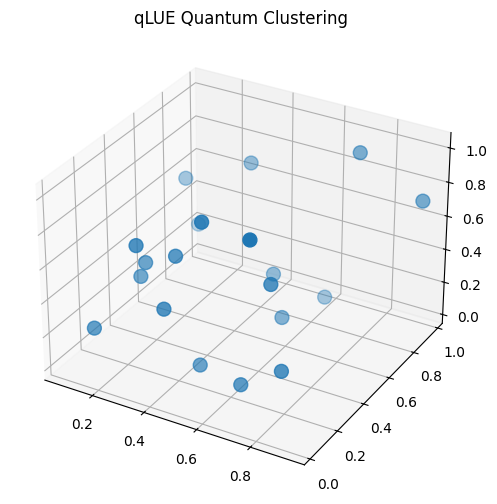

In [41]:
unique_clusters = np.unique(clusters)
cmap = plt.get_cmap("tab10", len(unique_clusters))

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                c=clusters, cmap=cmap, s=100)
plt.title("qLUE Quantum Clustering")
# plt.colorbar(sc, ticks=range(len(unique_clusters)))
plt.show()


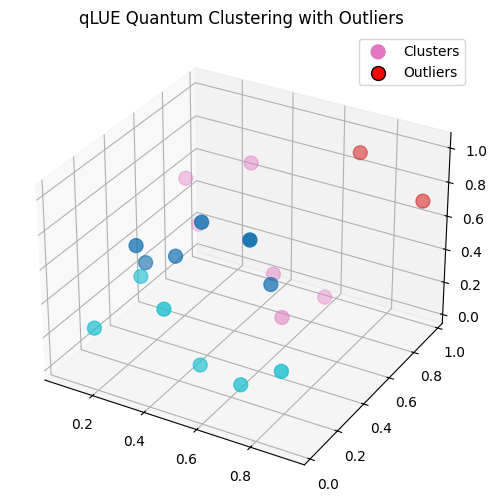

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot inliers (non-outliers) using tab10 colormap
inlier_mask = clusters != -1
inlier_clusters = clusters[inlier_mask]
unique_inlier_clusters = np.unique(inlier_clusters)
cmap = plt.get_cmap("tab10", len(unique_inlier_clusters))

sc = ax.scatter(points[inlier_mask, 0],
                points[inlier_mask, 1],
                points[inlier_mask, 2],
                c=inlier_clusters,
                cmap=cmap,
                s=100,
                label="Clusters")

# Plot outliers in red with black edge
outlier_mask = clusters == -1
ax.scatter(points[outlier_mask, 0],
           points[outlier_mask, 1],
           points[outlier_mask, 2],
           color='red',
           edgecolor='black',
           s=100,
           label="Outliers")

ax.set_title("qLUE Quantum Clustering with Outliers")
ax.legend()
plt.show()


In [9]:
outlier_indices = [i for i, c in enumerate(clusters) if c >= 5]
print("Likely outlier points:", outlier_indices)

Likely outlier points: []


In [10]:
print("Stats:")
for i in range(num_points):
    nj = nearest_higher[i]
    print(f"Point {i:2d}: ρ = {densities[i]:.4f}, dist to Nj = {dist_matrix[i, nj]:.4f}")


Stats:
Point  0: ρ = 0.0835, dist to Nj = 0.2755
Point  1: ρ = 0.0835, dist to Nj = 0.1791
Point  2: ρ = 0.0835, dist to Nj = 0.5393
Point  3: ρ = 0.0835, dist to Nj = 0.2554
Point  4: ρ = 0.0835, dist to Nj = 0.3397
Point  5: ρ = 0.0835, dist to Nj = 0.2997
Point  6: ρ = 0.0835, dist to Nj = 0.1774
Point  7: ρ = 0.0835, dist to Nj = 0.2975
Point  8: ρ = 0.0835, dist to Nj = 0.2830
Point  9: ρ = 0.0835, dist to Nj = 0.3370
Point 10: ρ = 0.0835, dist to Nj = 0.4138
Point 11: ρ = 0.0835, dist to Nj = 0.3060
Point 12: ρ = 0.0835, dist to Nj = 0.2952
Point 13: ρ = 0.0835, dist to Nj = 0.3071
Point 14: ρ = 0.0835, dist to Nj = 0.4305
Point 15: ρ = 0.0835, dist to Nj = 0.4457
Point 16: ρ = 0.0835, dist to Nj = 0.0000
Point 17: ρ = 0.0835, dist to Nj = 0.0000
Point 18: ρ = 0.0835, dist to Nj = 0.0000
Point 19: ρ = 0.0835, dist to Nj = 0.0000


In [11]:
for i in range(15, 20):
    for j in range(i+1, 20):
        print(f"dist({i},{j}) = {np.linalg.norm(points[i] - points[j]):.4f}")

dist(15,16) = 0.4457
dist(15,17) = 0.7226
dist(15,18) = 0.8147
dist(15,19) = 0.6534
dist(16,17) = 0.8097
dist(16,18) = 1.1944
dist(16,19) = 0.7583
dist(17,18) = 0.8973
dist(17,19) = 1.2342
dist(18,19) = 1.0142


In [42]:
marked = distance_oracle(16, dist_matrix, radius=2)
print("Marked neighbors of point 16:", marked)

if marked:
    probs = grover_iterations(marked, num_iter=2)
    for i in range(len(probs)):
        if probs[i] > 1e-4:
            print(f"|{i:05b}⟩: prob = {probs[i]:.4f}")
    print("ρ(16) = ", sum(probs[i] for i in marked))
else:
    print("No marked neighbors — expected ρ = 0")

Marked neighbors of point 16: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19]


TypeError: only length-1 arrays can be converted to Python scalars

In [13]:
print("Distances from point 16:")
for i in range(num_points):
    if i != 16:
        print(f"dist(16, {i}) = {dist_matrix[16, i]:.4f}")

Distances from point 16:
dist(16, 0) = 0.8121
dist(16, 1) = 0.8932
dist(16, 2) = 0.8933
dist(16, 3) = 0.2554
dist(16, 4) = 0.8022
dist(16, 5) = 0.5286
dist(16, 6) = 0.3327
dist(16, 7) = 0.6258
dist(16, 8) = 0.9376
dist(16, 9) = 0.9304
dist(16, 10) = 0.8823
dist(16, 11) = 0.9377
dist(16, 12) = 0.2952
dist(16, 13) = 0.4973
dist(16, 14) = 1.1290
dist(16, 15) = 0.4457
dist(16, 17) = 0.8097
dist(16, 18) = 1.1944
dist(16, 19) = 0.7583


In [14]:
from sklearn.datasets import make_blobs

# Parameters
num_clusters = 3
points_per_cluster = 5
num_outliers = 5
cluster_std = 0.5  # tight blobs

# 1. Generate clustered data
X_clusters, _ = make_blobs(n_samples=num_clusters * points_per_cluster,
                           centers=num_clusters, n_features=3,
                           cluster_std=cluster_std, random_state=42)

# 2. Generate distant outliers
X_outliers = np.random.uniform(low=10, high=15, size=(num_outliers, 3))

# 3. Combine into one dataset
points = np.vstack([X_clusters, X_outliers])
num_points = len(points)
num_qubits = int(np.ceil(np.log2(num_points)))

# 4. Recalculate distances
dist_matrix = np.linalg.norm(points[:, None, :] - points[None, :, :], axis=2)


In [26]:
index = 5
probs = grover_iterations(index, num_iter=1)

for i, p in enumerate(probs):
    if p > 0.01:
        print(f"Index {i:02d} → Probability {p:.3f}")


Index 00 → Probability 0.038
Index 01 → Probability 0.022
Index 02 → Probability 0.038
Index 03 → Probability 0.030
Index 04 → Probability 0.038
Index 05 → Probability 0.030
Index 06 → Probability 0.038
Index 07 → Probability 0.030
Index 08 → Probability 0.022
Index 09 → Probability 0.022
Index 10 → Probability 0.026
Index 11 → Probability 0.026
Index 12 → Probability 0.022
Index 13 → Probability 0.022
Index 14 → Probability 0.026
Index 15 → Probability 0.026
Index 16 → Probability 0.026
Index 17 → Probability 0.030
Index 18 → Probability 0.026
Index 19 → Probability 0.030
Index 20 → Probability 0.038
Index 21 → Probability 0.050
Index 22 → Probability 0.026
Index 23 → Probability 0.030
Index 24 → Probability 0.038
Index 25 → Probability 0.022
Index 26 → Probability 0.022
Index 27 → Probability 0.038
Index 28 → Probability 0.038
Index 29 → Probability 0.022
Index 30 → Probability 0.050
Index 31 → Probability 0.050


In [115]:
nearest_higher = compute_all_nearest_highers(densities, d_max)
print("Point | ρ(i)   | nh(i) | is_seed")
for i in range(num_points):
    print(f"{i:5} | {densities[i]:.3f} | {nearest_higher[i]:5} | {nearest_higher[i] == i}")


Point | ρ(i)   | nh(i) | is_seed
    0 | 0.400 |     0 | True
    1 | 0.427 |     0 | False
    2 | 0.400 |     0 | False
    3 | 0.480 |     0 | False
    4 | 0.468 |     0 | False
    5 | 0.421 |     0 | False
    6 | 0.468 |     2 | False
    7 | 0.421 |     0 | False
    8 | 0.492 |     2 | False
    9 | 0.492 |     2 | False
   10 | 0.482 |     0 | False
   11 | 0.435 |     0 | False
   12 | 0.492 |     2 | False
   13 | 0.435 |     0 | False
   14 | 0.482 |     2 | False
   15 | 0.482 |     2 | False
   16 | 0.435 |     1 | False
   17 | 0.428 |     0 | False
   18 | 0.435 |     1 | False
   19 | 0.487 |     0 | False


In [116]:
print("Densities:", np.round(densities, 3))

Densities: [0.4   0.427 0.4   0.48  0.468 0.421 0.468 0.421 0.492 0.492 0.482 0.435
 0.492 0.435 0.482 0.482 0.435 0.428 0.435 0.487]


In [117]:
for i in range(num_points):
    print(f"{i:2d}: rho={densities[i]:.3f}, nh={nearest_higher[i]:2d}, is_seed={nearest_higher[i] == i}")


 0: rho=0.400, nh= 0, is_seed=True
 1: rho=0.427, nh= 0, is_seed=False
 2: rho=0.400, nh= 0, is_seed=False
 3: rho=0.480, nh= 0, is_seed=False
 4: rho=0.468, nh= 0, is_seed=False
 5: rho=0.421, nh= 0, is_seed=False
 6: rho=0.468, nh= 2, is_seed=False
 7: rho=0.421, nh= 0, is_seed=False
 8: rho=0.492, nh= 2, is_seed=False
 9: rho=0.492, nh= 2, is_seed=False
10: rho=0.482, nh= 0, is_seed=False
11: rho=0.435, nh= 0, is_seed=False
12: rho=0.492, nh= 2, is_seed=False
13: rho=0.435, nh= 0, is_seed=False
14: rho=0.482, nh= 2, is_seed=False
15: rho=0.482, nh= 2, is_seed=False
16: rho=0.435, nh= 1, is_seed=False
17: rho=0.428, nh= 0, is_seed=False
18: rho=0.435, nh= 1, is_seed=False
19: rho=0.487, nh= 0, is_seed=False


In [118]:
print("Point 0 → ρ =", densities[0])
print("Nearest higher:", nearest_higher[0])
print("Distance to itself:", np.linalg.norm(points[0] - points[0]))

Point 0 → ρ = 0.3996977806091279
Nearest higher: 0
Distance to itself: 0.0


In [132]:
# --- Fully Quantum qLUE Clustering ---

import numpy as np
import pennylane as qml
from collections import Counter

# --- PARAMETERS ---
num_points = 20
num_qubits = int(np.ceil(np.log2(num_points)))
bit_width = max(3, int(np.ceil(np.log2(8))))  # ensures width for encoding integers up to 7
extra_ancilla = 12

dev = qml.device("default.qubit", wires=num_qubits + extra_ancilla)

critical_radius = 2.0
rho_threshold = 0.005
distance_threshold = 1.0

# --- GENERATE DATA ---
np.random.seed(42)
points = np.random.rand(num_points, 3)
points += 0.05 * np.random.randn(*points.shape)
dist_matrix = np.linalg.norm(points[:, None, :] - points[None, :, :], axis=2)

# --- QUANTUM ENCODING (Norm-based 3-bit) ---
norms = np.linalg.norm(points, axis=1)
x_data = np.round(norms * 7 / np.max(norms)).astype(int)  # 3-bit encoding

# --- ORACLE ---
def apply_oracle(x_data, rho_data, x_j, rho_j, dL, dT):
    idx_wires = list(range(num_qubits))
    xi_wires = list(range(num_qubits, num_qubits + 3))
    rhoi_wires = list(range(num_qubits + 3, num_qubits + 6))
    dist2_wires = list(range(num_qubits + 6, num_qubits + 9))
    anc_dlow = num_qubits + 9
    anc_dhigh = num_qubits + 10
    anc_rho = num_qubits + 11

    for i in range(len(x_data)):
        bits = np.binary_repr(i, width=num_qubits)[::-1]
        cond = [idx_wires[j] for j, b in enumerate(bits) if b == '1']
        if cond:
            for j, b in enumerate(np.binary_repr(x_data[i], width=3)[::-1]):
                if b == '1':
                    qml.ctrl(qml.PauliX, control=cond)(wires=xi_wires[j])
            for j, b in enumerate(np.binary_repr(rho_data[i], width=3)[::-1]):
                if b == '1':
                    qml.ctrl(qml.PauliX, control=cond)(wires=rhoi_wires[j])

    for j in range(3):
        if (x_j >> j) & 1:
            qml.PauliX(wires=xi_wires[j])
    for j in range(3):
        qml.CNOT(wires=[xi_wires[j], dist2_wires[j]])
    for j in range(3):
        if (x_j >> j) & 1:
            qml.PauliX(wires=xi_wires[j])

    def compare_greater(a_wires, b_val, ancilla):
        width = len(a_wires)
        max_val = 2 ** width - 1
        clipped_val = min(int(b_val), max_val)
        b_bits = np.binary_repr(clipped_val, width=width)[::-1]
        for i in range(width):
            if b_bits[i] == '0':
                qml.PauliX(wires=a_wires[i])
        qml.MultiControlledX(wires=a_wires + [ancilla])
        for i in range(width):
            if b_bits[i] == '0':
                qml.PauliX(wires=a_wires[i])

    compare_greater(dist2_wires, int(dL), anc_dlow)
    compare_greater(dist2_wires, int(dT), anc_dhigh)
    compare_greater(rhoi_wires, rho_j, anc_rho)

    qml.MultiControlledX(wires=[anc_dlow, anc_dhigh, anc_rho, idx_wires[-1]])


# --- DIFFUSION ---
def diffusion_operator():
    for wire in range(num_qubits):
        qml.Hadamard(wires=wire)
        qml.PauliX(wires=wire)
    qml.Hadamard(wires=num_qubits - 1)
    qml.MultiControlledX(wires=list(range(num_qubits)))
    qml.Hadamard(wires=num_qubits - 1)
    for wire in range(num_qubits):
        qml.PauliX(wires=wire)
        qml.Hadamard(wires=wire)

# --- GROVER ---
def grover_iterations(index, num_iter=2, dL=0, dT=critical_radius, rho_data=None, densities=None):
    x_j = x_data[index]
    rho_j = int(np.round(densities[index] * 7))

    @qml.qnode(dev)
    def circuit():
        for wire in range(num_qubits):
            qml.Hadamard(wires=wire)
        apply_oracle(
            x_data=x_data,
            rho_data=np.round(densities * 7).astype(int),
            x_j=x_j,
            rho_j=rho_j,
            dL=int(dL),
            dT=int(dT)
        )
        diffusion_operator()
        return qml.probs(wires=range(num_qubits))

    return circuit()[:num_points]

# --- QUANTUM SEED DETECTION ---
def detect_seeds_quantum(densities):
    rho_data = np.round(densities * 7).astype(int)
    seeds = []
    for i in range(num_points):
        @qml.qnode(dev)
        def circuit():
            for wire in range(num_qubits):
                qml.Hadamard(wires=wire)
            apply_oracle(
                x_data=x_data,
                rho_data=rho_data,
                x_j=x_data[i],
                rho_j=rho_data[i],
                dL=int(distance_threshold),
                dT=99
            )
            diffusion_operator()
            return qml.probs(wires=range(num_qubits))

        probs = circuit()
        if probs[i] > 0.1:
            seeds.append(i)
    return seeds

def assign_followers_quantum(seeds, nearest_higher, densities):
    rho_data = np.round(densities * 7).astype(int)
    clusters = np.full(num_points, -1)
    for cid, seed in enumerate(seeds):
        clusters[seed] = cid

    for i in range(num_points):
        if clusters[i] != -1:
            continue

        @qml.qnode(dev)
        def circuit():
            for wire in range(num_qubits):
                qml.Hadamard(wires=wire)
            apply_oracle(
                x_data=x_data,
                rho_data=rho_data,
                x_j=x_data[i],
                rho_j=rho_data[i],
                dL=0,
                dT=critical_radius
            )
            diffusion_operator()
            return qml.probs(wires=range(num_qubits))

        probs = circuit()
        j = np.argmax(probs[:num_points])  # restrict to valid indices
        if j < len(nearest_higher) and clusters[nearest_higher[j]] != -1:
            clusters[i] = clusters[nearest_higher[j]]

    return clusters


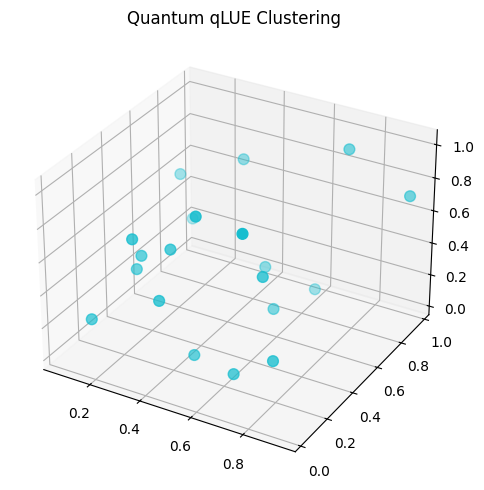

Cluster labels: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Seeds: []


In [133]:
# --- Fully Quantum qLUE Clustering ---

import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
from collections import Counter

# --- PARAMETERS ---
num_points = 20
num_qubits = int(np.ceil(np.log2(num_points)))
dev = qml.device("default.qubit", wires=num_qubits + 12)

critical_radius = 2.0
rho_threshold = 0.005
distance_threshold = 1.0

# --- GENERATE DATA ---
np.random.seed(42)
points = np.random.rand(num_points, 3)
points += 0.05 * np.random.randn(*points.shape)
dist_matrix = np.linalg.norm(points[:, None, :] - points[None, :, :], axis=2)

# --- QUANTUM ENCODING (Norm-based 3-bit) ---
norms = np.linalg.norm(points, axis=1)
x_data = np.round(norms * 7 / np.max(norms)).astype(int)  # 3-bit encoding

# --- QUANTUM DENSITY ESTIMATION ---
def compute_local_densities():
    densities = []
    for i in range(num_points):
        @qml.qnode(dev)
        def circuit():
            for wire in range(num_qubits):
                qml.Hadamard(wires=wire)
            apply_oracle(
                x_data=x_data,
                rho_data=np.zeros(num_points, dtype=int),  # not needed here
                x_j=x_data[i],
                rho_j=0,
                dL=0,
                dT=critical_radius
            )
            diffusion_operator()
            return qml.probs(wires=range(num_qubits))

        probs = circuit()
        densities.append(probs[i])
    return np.array(densities)

# --- QUANTUM NEAREST HIGHER COMPUTATION ---
def compute_nearest_higher(densities):
    rho_data = np.round(densities * 7).astype(int)
    nearest_higher = []
    for i in range(num_points):
        best_j = i
        best_score = 0

        @qml.qnode(dev)
        def circuit():
            for wire in range(num_qubits):
                qml.Hadamard(wires=wire)
            apply_oracle(
                x_data=x_data,
                rho_data=rho_data,
                x_j=x_data[i],
                rho_j=rho_data[i],
                dL=0,
                dT=critical_radius
            )
            diffusion_operator()
            return qml.probs(wires=range(num_qubits))

        probs = circuit()
        for j in range(num_points):
            if densities[j] > densities[i] and probs[j] > best_score:
                best_score = probs[j]
                best_j = j

        nearest_higher.append(best_j)
    return np.array(nearest_higher)

# --- MAIN EXECUTION ---
densities = compute_local_densities()
nearest_higher = compute_nearest_higher(densities)
seeds = detect_seeds_quantum(densities)
clusters = assign_followers_quantum(seeds, nearest_higher, densities)

# --- PLOT RESULTS ---
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
colors = plt.cm.tab10((clusters % 10) / 10)
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, s=60)
ax.set_title("Quantum qLUE Clustering")
plt.tight_layout()
plt.show()

print("Cluster labels:", clusters)
print("Seeds:", seeds)
